<a href="https://colab.research.google.com/github/isdeniz/msc-2024/blob/main/roberta_nlbse22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers==4.40.2

In [2]:
pip install simpletransformers==0.64.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.6 MB/s eta 0:00:00
   ━

In [3]:
import transformers
>>> transformers.__version__

'4.40.2'

In [4]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix # additional line
import seaborn as sns # additional line
import matplotlib.pyplot as plt # additional line
import torch.multiprocessing # additional line
import os # additional line
os.environ["TOKENIZERS_PARALLELISM"] = "false" # additional line
torch.multiprocessing.set_start_method('spawn', force = True) # additional line
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [5]:
train = pd.read_csv('data/train_clean_concat_200.csv')
test = pd.read_csv('data/test_clean_concat_200.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (696679, 2) (80518, 2)


In [6]:
train.head()

,text,labels
0,time 2021-05-26T20:57:00Z author OWNER repo 0-Yama/Projet-Final-Python title the beginning body we need to add the first file of our project,1
1,time 2020-07-26T20:14:04Z author OWNER repo 0-vortex/dotfiles title better touch tool configuration body export better touch tool configuration as a separate package or submodule,1
2,time 2020-12-04T09:33:18Z author NONE repo 00-Evan/shattered-pixel-dungeon title request text when wand of regrowth starts producing furrowed grass body i was super confused when this happened. a bit of text would have helped me realize what was going on a lot sooner. the wand is getting old and the new grass is not as healthy. ?,1
3,time 2020-09-22T01:49:32Z author OWNER repo 003MattB/ScheduleBuilderImproved title update total credits when cards are removed body total credits is only updated when adding new courses but is never updated when cards are removed,0
4,time 2020-09-22T01:52:14Z author OWNER repo 003MattB/ScheduleBuilderImproved title delete course from matrix body there is no way to remove courses from the matrix once they have been added. don't forget to update the total credits see issue,1


In [7]:
test.head()

,text,labels
0,time 2020-04-07T09:08:50Z author NONE repo tlnagy/TIFF.jl title error keyerror key tiff.sampleformat_int 0x0008 not found body one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1,1
1,time 2020-11-27T07:17:21Z author OWNER repo tisboyo/Twitch_Bot title add database backup to dropbox body nan,1
2,time 2021-01-02T19:35:34Z author OWNER repo DrWhoCares/imgdanke title add a button method to open the source or output folders body could also add a method to open up path to each file in the file list by right clicking. also an option to open up the path to the imgdanke.exe.,1
3,time 2021-01-02T20:55:34Z author OWNER repo DrWhoCares/imgdanke title processes are being started twice body at some point i refactored a few things and ended up leaving in an additional call to function that should've just been replaced by the using process process function call.,0
4,time 2020-12-29T15:34:35Z author OWNER repo Bean-1/AOT title cannot add hp to wall body nan,0


set the classification layer and training parameters

In [8]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq = 200
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [9]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [10]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 07/08/2024-09:42 -----


  0%|          | 0/696679 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/6967 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/6967 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6967 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6967 [00:00<?, ?it/s]

(27868, 0.32463359093827987)

evaluate the model

In [11]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 1h:21m:3s ----- 




  0%|          | 0/80518 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/806 [00:00<?, ?it/s]

{'mcc': 0.7764113334705744,
 'accuracy': 0.8726620134628282,
 'p_micro': 0.8726620134628282,
 'p_macro': 0.8302840238794257,
 'p_w': 0.871521339480704,
 'r_micro': 0.8726620134628282,
 'r_macro': 0.8158405668318558,
 'r_w': 0.8726620134628282,
 'f_micro': 0.8726620134628282,
 'f_macro': 0.8226713941021062,
 'f_w': 0.8719798246033517,
 'classificationReport': {'0.0': {'precision': 0.8923667503322014,
   'recall': 0.9001191421763304,
   'f1-score': 0.8962261819439983,
   'support': 40288.0},
  '1.0': {'precision': 0.8782444690596652,
   'recall': 0.8835346203656296,
   'f1-score': 0.8808816022580548,
   'support': 33203.0},
  '2.0': {'precision': 0.7202408522464103,
   'recall': 0.6638679379536075,
   'f1-score': 0.6909063981042655,
   'support': 7027.0},
  'accuracy': 0.8726620134628282,
  'macro avg': {'precision': 0.8302840238794257,
   'recall': 0.8158405668318558,
   'f1-score': 0.8226713941021062,
   'support': 80518.0},
  'weighted avg': {'precision': 0.871521339480704,
   'recall

get the confusion matrix

In [12]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'question'])

In [13]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [14]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)

In [15]:
model_outputs_df['actual'] = test['labels']

In [16]:
label_names = ['bug', 'enhancement', 'question']

In [17]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

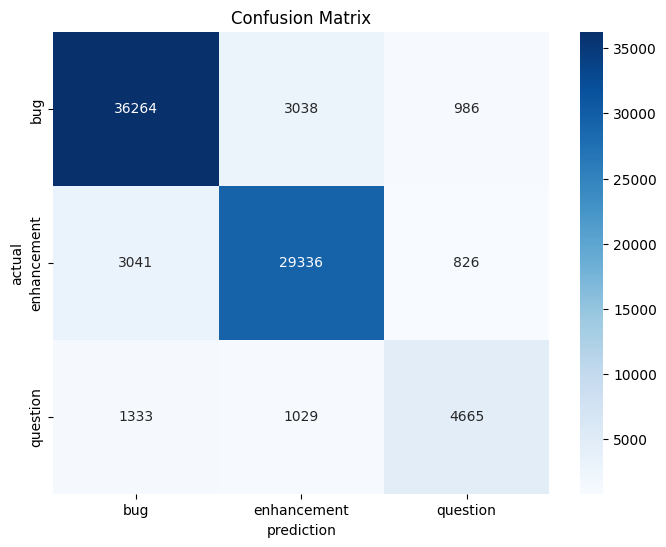

In [18]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions

In [19]:
predictions = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])

In [20]:
predictions['text'] = test['text']
predictions['labels'] = test['labels']
predictions['actual_labels'] = model_outputs_df['actual']
predictions['prediction'] = model_outputs_df['prediction']
predictions.head()

,text,labels,actual_labels,prediction
0,time 2020-04-07T09:08:50Z author NONE repo tlnagy/TIFF.jl title error keyerror key tiff.sampleformat_int 0x0008 not found body one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1,1,1,0
1,time 2020-11-27T07:17:21Z author OWNER repo tisboyo/Twitch_Bot title add database backup to dropbox body nan,1,1,1
2,time 2021-01-02T19:35:34Z author OWNER repo DrWhoCares/imgdanke title add a button method to open the source or output folders body could also add a method to open up path to each file in the file list by right clicking. also an option to open up the path to the imgdanke.exe.,1,1,1
3,time 2021-01-02T20:55:34Z author OWNER repo DrWhoCares/imgdanke title processes are being started twice body at some point i refactored a few things and ended up leaving in an additional call to function that should've just been replaced by the using process process function call.,0,0,0
4,time 2020-12-29T15:34:35Z author OWNER repo Bean-1/AOT title cannot add hp to wall body nan,0,0,0


In [21]:
predictions.to_csv('data/nlbse22_test_bert_preds.csv')

In [22]:
predictions.to_pickle('data/nlbse22_test_bert_preds.pkl')